In [73]:
# imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# import basic libraries
import os
from glob import glob

# import plotting
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import matplotlib
import seaborn as sns

# import image manipulation
from PIL import Image
import imageio

# import data augmentation
import imgaug as ia
from imgaug import augmenters as iaa

![image](https://github.com/Lexie88rus/understanding_clouds/raw/master/assets/bay-beach-beautiful-2876737.jpg)

Photo by [Vincent Rivaud from Pexels](https://www.pexels.com/@vince?utm_content=attributionCopyText&utm_medium=referral&utm_source=pexels)

# Understanding Clouds EDA
*Comprehensive overview of the [competition](https://www.kaggle.com/c/understanding_cloud_organization/data) data*

## About the Competition

## Load Data

Firts, let's define the paths to train and test images and load the dataframe with train images:

In [7]:
# set paths to train and test image datasets
TRAIN_PATH = '../input/understanding_cloud_organization/train_images/'
TEST_PATH = '../input/understanding_cloud_organization/test_images/'

# load dataframe with train labels
train_df = pd.read_csv('../input/understanding_cloud_organization/train.csv')

print('There are {} images in the train set.'.format(len(train_df)))

There are 22184 images in train set.


Now let's load explore the test set a little:

In [12]:
# load the filenames for test images
test_fns = sorted(glob(TEST_PATH + '*.jpg'))

print('There are {} images in the test set.'.format(len(test_fns)))

There are 3698 images in the test set.


Plot the pie chart for the train and test datasets:

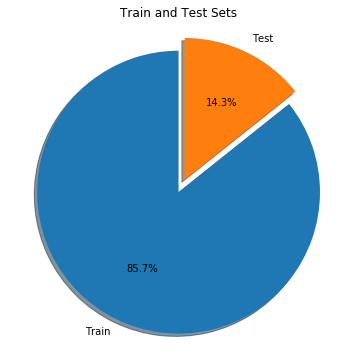

In [16]:
# plotting a pie chart which demonstrates train and test sets
labels = 'Train', 'Test'
sizes = [len(train_df), len(test_fns)]
explode = (0, 0.1)

fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal')
ax.set_title('Train and Test Sets')

plt.show()

## Explore Labels from Train Set

Look how the dataframe with train labels looks like:

In [17]:
train_df.head()

,Image_Label,EncodedPixels
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
2,0011165.jpg_Gravel,NaN
3,0011165.jpg_Sugar,NaN
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...


We can see that:
* For each image from the training dataset there are __4 lines for each type of clouds__.
* `Image_Label` is a __contatenation of the image filename and a cloud type__.
* If a certain type of clouds in present on the image, the `EncodedPixels` column is non-null and contains the __segmentation map for the corresponding cloud type__.

`1.` Explore null values:

Now let's see how many null values are there:

In [19]:
print('There are {} rows with empty segmentation maps.'.format(len(train_df) - train_df.EncodedPixels.count()))

There are 10348 rows with empty segmentation maps.


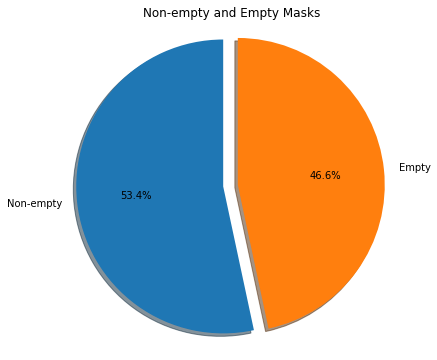

In [20]:
# plotting a pie chart
labels = 'Non-empty', 'Empty'
sizes = [train_df.EncodedPixels.count(), len(train_df) - train_df.EncodedPixels.count()]
explode = (0, 0.1)

fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal')
ax.set_title('Non-empty and Empty Masks')

plt.show()

Looks like almost __half of the lines is empty__.

`2.` Explore the labels:

Let's split the `Image_Label` into two columns and analyze the labels:

In [24]:
# split column
split_df = train_df["Image_Label"].str.split("_", n = 1, expand = True)
# add new columns to train_df
train_df['Image'] = split_df[0]
train_df['Label'] = split_df[1]

# check the result
train_df.head()

,Image_Label,EncodedPixels,Image,Label
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,Fish
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,Flower
2,0011165.jpg_Gravel,NaN,0011165.jpg,Gravel
3,0011165.jpg_Sugar,NaN,0011165.jpg,Sugar
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...,002be4f.jpg,Fish


Now we can count the number of labels of each cloud type:

In [28]:
fish = train_df[train_df['Label'] == 'Fish'].EncodedPixels.count()
flower = train_df[train_df['Label'] == 'Flower'].EncodedPixels.count()
gravel = train_df[train_df['Label'] == 'Gravel'].EncodedPixels.count()
sugar = train_df[train_df['Label'] == 'Sugar'].EncodedPixels.count()

print('There are {} fish clouds'.format(fish))
print('There are {} flower clouds'.format(flower))
print('There are {} gravel clouds'.format(gravel))
print('There are {} sugar clouds'.format(sugar))

There are 2781 fish clouds
There are 2365 flower clouds
There are 2939 gravel clouds
There are 3751 sugar clouds


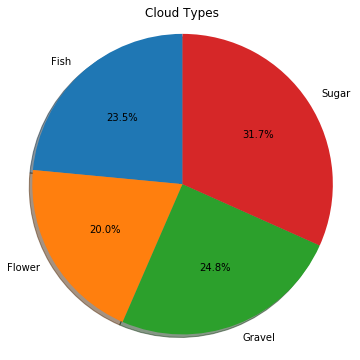

In [30]:
# plotting a pie chart
labels = 'Fish', 'Flower', 'Gravel', 'Sugar'
sizes = [fish, flower, gravel, sugar]

fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal')
ax.set_title('Cloud Types')

plt.show()

We can see that at least the dataset is somewhat __balanced__, which is great and makes are task way more easier.

`3.` Explore the number of labels per image:

In [38]:
labels_per_image = train_df.groupby('Image')['EncodedPixels'].count()

In [46]:
print('The mean number of labels per image is {}'.format(labels_per_image.mean()))

The mean number of labels per image is 2.134150739271547


Text(0.5, 1.0, 'Number of Labels per Image')

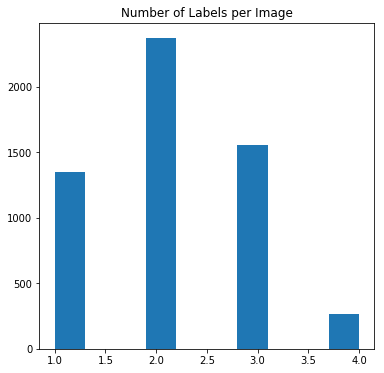

In [43]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.hist(labels_per_image)
ax.set_title('Number of Labels per Image')

__So most of the images have 2 labels.__

`4.` Explore the correlation between different cloud types.

Using the dataframe with labels, we can try to find the correlation between different types of clouds.

In [71]:
# create dummy columns for each cloud type
corr_df = pd.get_dummies(train_df, columns = ['Label'])
# fill null values with '-1'
corr_df = corr_df.fillna('-1')

# define a helper function to fill dummy columns
def get_dummy_value(row, cloud_type):
    ''' Get value for dummy column '''
    if cloud_type == 'fish':
        return row['Label_Fish'] * (row['EncodedPixels'] != '-1')
    if cloud_type == 'flower':
        return row['Label_Flower'] * (row['EncodedPixels'] != '-1')
    if cloud_type == 'gravel':
        return row['Label_Gravel'] * (row['EncodedPixels'] != '-1')
    if cloud_type == 'sugar':
        return row['Label_Sugar'] * (row['EncodedPixels'] != '-1')
    
# fill dummy columns
corr_df['Label_Fish'] = corr_df.apply(lambda row: get_dummy_value(row, 'fish'), axis=1)
corr_df['Label_Flower'] = corr_df.apply(lambda row: get_dummy_value(row, 'flower'), axis=1)
corr_df['Label_Gravel'] = corr_df.apply(lambda row: get_dummy_value(row, 'gravel'), axis=1)
corr_df['Label_Sugar'] = corr_df.apply(lambda row: get_dummy_value(row, 'sugar'), axis=1)

# check the result
corr_df.head()

,Image_Label,EncodedPixels,Image,Label_Fish,Label_Flower,Label_Gravel,Label_Sugar
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,1,0,0,0
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,0,1,0,0
2,0011165.jpg_Gravel,-1,0011165.jpg,0,0,0,0
3,0011165.jpg_Sugar,-1,0011165.jpg,0,0,0,0
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...,002be4f.jpg,1,0,0,0


In [72]:
# group by the image
corr_df = corr_df.groupby('Image')['Label_Fish', 'Label_Flower', 'Label_Gravel', 'Label_Sugar'].max()
corr_df.head()

,Label_Fish,Label_Flower,Label_Gravel,Label_Sugar
Image,,,,
0011165.jpg,1,1,0,0
002be4f.jpg,1,1,0,1
0031ae9.jpg,1,1,0,1
0035239.jpg,0,1,1,0
003994e.jpg,1,0,1,1


Now we can explore the correlation between `Label_Fish, Label_Flower, Label_Gravel, Label_Sugar` columns:

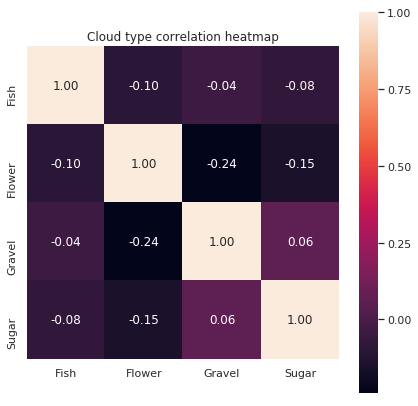

In [81]:
#Find out correlation between columns and plot
corrs = np.corrcoef(corr_df.values.T)
sns.set(font_scale=1)
sns.set(rc={'figure.figsize':(7,7)})
hm=sns.heatmap(corrs, cbar = True, annot=True, square = True, fmt = '.2f',
              yticklabels = ['Fish', 'Flower', 'Gravel', 'Sugar'], 
               xticklabels = ['Fish', 'Flower', 'Gravel', 'Sugar']).set_title('Cloud type correlation heatmap')

fig = hm.get_figure()

As we can observe, there is __no strong correlation between the types of the clouds__ on one image. But there might be less likely to find `gravel` and `flower` clouds on one image. 

## Explore the Images

Here goes the most exciting part of the EDA: exploring the images themselves.

`1.` Explore image sizes:

In [49]:
def get_image_sizes(train = True):
    '''
    Function to get sizes of images from test and train sets.
    INPUT:
        train - indicates whether we are getting sizes of images from train or test set
    '''
    if train:
        path = TRAIN_PATH
    else:
        path = TEST_PATH
        
    widths = []
    heights = []
    
    images = sorted(glob(path + '*.jpg'))
    
    max_im = Image.open(images[0])
    min_im = Image.open(images[0])
        
    for im in range(0, len(images)):
        image = Image.open(images[im])
        width, height = image.size
        
        if len(widths) > 0:
            if width > max(widths):
                max_im = image

            if width < min(widths):
                min_im = image

        widths.append(width)
        heights.append(height)
        
    return widths, heights, max_im, min_im

In [50]:
# get sizes of images from test and train sets
train_widths, train_heights, max_train, min_train = get_image_sizes(train = True)
test_widths, test_heights, max_test, min_test = get_image_sizes(train = False)

print('Maximum width for training set is {}'.format(max(train_widths)))
print('Minimum width for training set is {}'.format(min(train_widths)))
print('Maximum height for training set is {}'.format(max(train_heights)))
print('Minimum height for training set is {}'.format(min(train_heights)))

Maximum width for training set is 2100
Minimum width for training set is 2100
Maximum height for training set is 1400
Minimum height for training set is 1400


In [51]:
print('Maximum width for test set is {}'.format(max(test_widths)))
print('Minimum width for test set is {}'.format(min(test_widths)))
print('Maximum height for test set is {}'.format(max(test_heights)))
print('Minimum height for test set is {}'.format(min(test_heights)))

Maximum width for test set is 2100
Minimum width for test set is 2100
Maximum height for test set is 1400
Minimum height for test set is 1400


We see that __all images have the same size__. That's great!

`2.` Plot sample images from training set:

In [120]:
def get_labels(image_id):
    ''' Function to get the labels for the image by name'''
    im_df = train_df[train_df['Image'] == image_id].fillna('-1')
    im_df = im_df[im_df['EncodedPixels'] != '-1'].groupby('Label').count()
    
    index = im_df.index
    all_labels = ['Fish', 'Flower', 'Gravel', 'Sugar']
    
    labels = ''
    
    for label in all_labels:
        if label in index:
            labels = labels + ' ' + label
    
    return labels

# function to plot a grid of images
def plot_training_images(width = 5, height = 2):
    """
    Function to plot grid with several examples of cloud images from train set.
    INPUT:
        width - number of images per row
        height - number of rows

    OUTPUT: None
    """
    
    # get a list of images from training set
    images = sorted(glob(TRAIN_PATH + '*.jpg'))
    
    fig, axs = plt.subplots(height, width, figsize=(15,5))
    
    # create a list of random indices 
    rnd_indices = rnd_indices = [np.random.choice(range(0, len(images))) for i in range(height * width)]
    
    for im in range(0, height * width):
        # open image with a random index
        image = Image.open(images[rnd_indices[im]])
        
        i = im // width
        j = im % width
        
        # plot the image
        axs[i,j].imshow(image) #plot the data
        axs[i,j].axis('off')
        axs[i,j].set_title(get_labels(images[rnd_indices[im]].split('/')[-1]))

    # set suptitle
    plt.suptitle('Sample images from train set')
    plt.show()

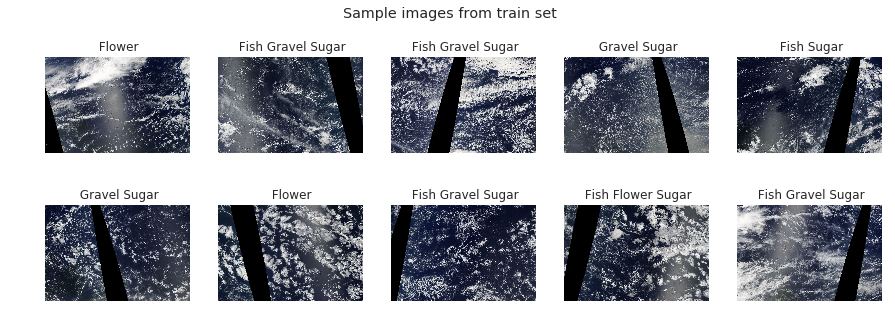

In [121]:
plot_training_images()